In [ ]:
# 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# 주가예측 폴더로 폴더위치 변경
%cd /content/gdrive/MyDrive/Colab Notebooks/Stock_Prediction/Datas

/content/gdrive/MyDrive/Colab Notebooks/Stock_Prediction/Datas


In [ ]:
# 기본 모듈 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

# 텐서플로 관련 모듈 임포트
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda, Bidirectional, Dropout
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 사이킷런 관련 모듈 임포트
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [ ]:
# 데이터 호출

# 파일 경로, 인코딩 설정
data_path = '/content/gdrive/MyDrive/Colab Notebooks/Stock_Prediction/Datas'
data_name =  'Samsung_Electronics_with_total_no_comma.csv'
file_encoding = 'utf8'

# 판다스 모듈로 csv 파일 읽어오기
df_price = pd.read_csv(os.path.join(data_path, data_name), encoding=file_encoding)

# 잘 읽어 왔는지 확인
df_price.describe()

,Open,High,Low,Close,Volume,T_volume,T_amount,T_foreigner,T_market_price
count,5086.000000,5086.000000,5086.000000,5086.000000,5.086000e+03,5.086000e+03,5086.000000,5086.000000,5.086000e+03
mean,30223.696422,30515.711758,29920.226111,30214.445537,1.852203e+07,7.486748e+04,58005.583759,-12.850177,1.141265e+07
std,21032.646369,21201.219295,20850.549307,21013.124972,1.014269e+07,2.063617e+06,36390.449184,2904.338930,5.081960e+06
min,5320.000000,5460.000000,5190.000000,5390.000000,2.765000e+04,1.067600e+04,10909.000000,-28300.000000,2.123860e+06
25%,12145.000000,12280.000000,12020.000000,12140.000000,1.139761e+07,3.114150e+04,36791.750000,-1331.750000,7.434985e+06
50%,25140.000000,25380.000000,24900.000000,25100.000000,1.595285e+07,3.949550e+04,48357.000000,15.000000,1.154058e+07
75%,46200.000000,46600.000000,45750.000000,46150.000000,2.293091e+07,5.242275e+04,67153.750000,1373.500000,1.419119e+07
max,90300.000000,96800.000000,89500.000000,91000.000000,9.030618e+07,1.472049e+08,440694.000000,17200.000000,2.339206e+07


0      2003-01-02
1      2003-01-03
2      2003-01-06
3      2003-01-07
4      2003-01-08
          ...    
5081   2023-08-23
5082   2023-08-24
5083   2023-08-25
5084   2023-08-28
5085   2023-08-29
Name: Date, Length: 5086, dtype: datetime64[ns]


Text(0, 0.5, 'price')

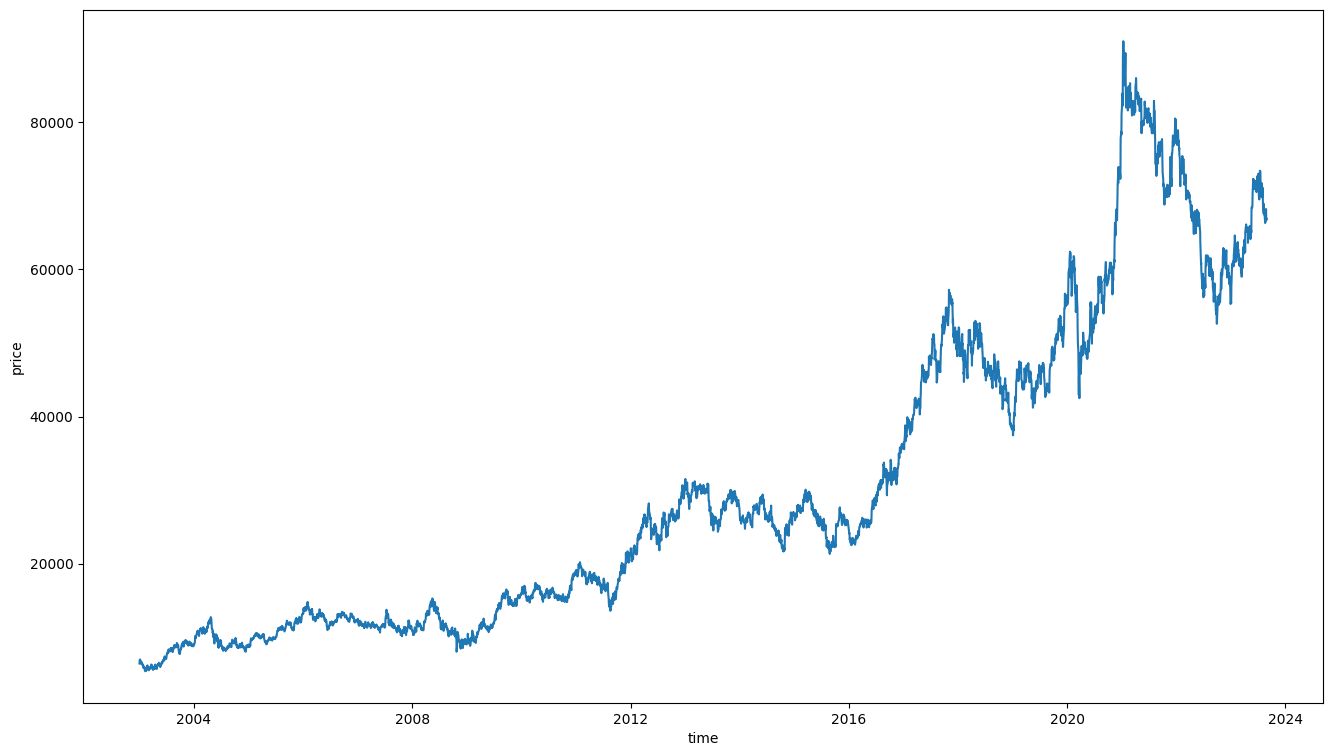

In [ ]:
# 일자 데이터를 2023-08-29 등의 형태로 설정

df_price['Date'] = pd.to_datetime(df_price['Date'], format='%Y-%m-%d')
df_price['Year'] =df_price['Date'].dt.year
df_price['Month'] =df_price['Date'].dt.month
df_price['Day'] =df_price['Date'].dt.day

# 일자 데이터 정렬
print(df_price['Date'])

# 전체 주가 시각화
plt.figure(figsize=(16, 9))
sns.lineplot(y=df_price['Close'], x=df_price['Date'])
plt.xlabel('time')
plt.ylabel('price')

In [ ]:
# 데이터 전처리 부분 - 사이킷런의 MinMaxScaler 사용
# 데이터를 전처리 하는 이유
# 1. 효율적인 학습을 위해
# 2. 주가 데이터는 가격, 거래량 간의 절대값 차이가 크기 때문에 0부터 1까지의 값으로 정규화 해 주어야 변화량에의 유의미한 영향을 확인 가능하기에
#   (가중치에 미치는 영향을 절대량이 아닌 변화량으로 적용하기 위해)
scaler = MinMaxScaler()
# 스케일을 적용할 column을 정의합니다.
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'T_volume', 'T_amount', 'T_foreigner', 'T_market_price']

# 스케일 후 columns
scaled = scaler.fit_transform(df_price[scale_cols])
scaled

# Pandas의 DataFrame 사용하여 전처리된 데이터셋을 다시 넣어준다
df = pd.DataFrame(scaled, columns=scale_cols)
# 확인
df

,Open,High,Low,Close,Volume,T_volume,T_amount,T_foreigner,T_market_price
0,0.012474,0.010948,0.013166,0.012148,0.283039,0.000432,0.006103,0.620659,0.023261
1,0.016239,0.016860,0.017198,0.017405,0.614790,0.000611,0.027446,0.677780,0.028339
2,0.019063,0.017189,0.020045,0.018689,0.276282,0.000418,0.011813,0.655714,0.029356
3,0.021888,0.018831,0.019571,0.017054,0.319759,0.000396,0.018128,0.651231,0.026573
4,0.018828,0.016094,0.018740,0.016470,0.278941,0.000338,0.009251,0.624725,0.026484
...,...,...,...,...,...,...,...,...,...
5081,0.722288,0.674841,0.726011,0.720827,0.105470,0.000292,0.168964,0.626505,0.834198
5082,0.741116,0.692358,0.743803,0.733676,0.166339,0.000222,0.205947,0.646286,0.846191
5083,0.726995,0.678126,0.731942,0.720827,0.077591,0.000315,0.165206,0.579890,0.839429
5084,0.723464,0.673746,0.727197,0.717323,0.064212,0.000250,0.163240,0.619011,0.847951


In [ ]:
# train 데이터셋, test 데이터셋 분할
# 사이킷런 train_test_split 이용
x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, random_state=0, shuffle=False)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

print(x_train)
print(y_train)

(4068, 8) (4068,)
(1018, 8) (1018,)
          Open      High       Low    Volume  T_volume  T_amount  T_foreigner  \
0     0.012474  0.010948  0.013166  0.283039  0.000432  0.006103     0.620659   
1     0.016239  0.016860  0.017198  0.614790  0.000611  0.027446     0.677780   
2     0.019063  0.017189  0.020045  0.276282  0.000418  0.011813     0.655714   
3     0.021888  0.018831  0.019571  0.319759  0.000396  0.018128     0.651231   
4     0.018828  0.016094  0.018740  0.278941  0.000338  0.009251     0.624725   
...        ...       ...       ...       ...       ...       ...          ...   
4063  0.465168  0.438362  0.470407  0.078869  0.000612  0.067566     0.618264   
4064  0.475759  0.441647  0.474558  0.104424  0.000390  0.093568     0.624945   
4065  0.469287  0.441647  0.474558  0.067097  0.000376  0.067601     0.600220   
4066  0.469287  0.441647  0.474558  0.078082  0.000359  0.072299     0.621604   
4067  0.476347  0.443836  0.479303  0.101890  0.000420  0.076757     0.62

<ipython-input-7-ad83ef6e20bc>:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, random_state=0, shuffle=False)


In [ ]:
# windowed dataset 구축 부분
# 해당 모델의 학습을 위해 핵심적인 부분!!

# 시계열 데이터 분석을 위해서는, 시퀀스 데이터 세트를 구성해 주어야 한다
#  * 시퀀스 데이터 세트란? 시간의 흐름에 따라 변화하는 데이터를 일정 크기로 묶은 것
#  * 텐서플로는 시퀀스 데이터 세트 구성을 편리하게 해줄 수 있는 여러 툴을 제공한다.
def windowed_dataset(series, window_size, batch_size, shuffle):

    # series의 마지막 차원을 확장하여 2D 텐서로 만든다. 이는 데이터셋 구축을 위해 필요함
    series = tf.expand_dims(series, axis=-1)

    # series를 기반으로 데이터셋을 생성 => 확장된 2D 텐서를 기반으로
    ds = tf.data.Dataset.from_tensor_slices(series)

    # window_size + 1 크기의 윈도우를 생성하고 각 윈도우를 1개의 단계씩 이동
    # drop_remainder=True로 설정하여 마지막에 남는 부분 윈도우를 제거 (하지 않으면 남는 부분의 shape가 달라져서 문제가 됨)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)

    # ds.flat_map(lambda w: w.batch(window_size + 1)): 각 윈도우를 플랫 맵을 사용하여 배치로 만들고 연결 => 중첩된 구조의 평면화
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))

    # 데이터의 셔플(무작위 섞기) 가 필요한 경우 1000개 단위로 셔플해줌
    # ex) 훈련 데이터
    if shuffle:
        ds = ds.shuffle(1000)

    # 훈련 데이터, 레이블 데이터 나누어줌
    # 이 데이터셋의 경우는 마지막 이전의 데이터가 훈련에 사용되고 마지막은 답임 (앞의 파라미터들로 종가를 구하는 모델이므로)
    ds = ds.map(lambda w: (w[:-1], w[-1]))

    # 데이터셋을 batch_size 크기로 나눔
    # 학습 속도를 향상시키기 위해 1개의 배치를 미리 가져오는(prefetching) prefetch(1)을 사용
    #   * prefetch : 해당 배치 학습 중에 다음 데이터 배치 미리 제작해주어 속도를 높임
    return ds.batch(batch_size).prefetch(1)

In [ ]:
# 사용될 하이퍼 파라미터 튜닝을 위해 변수로 선언 및 초기화
# 윈도우(프레임) 사이즈
WINDOW_SIZE=20
# 배치 사이즈
BATCH_SIZE=32

In [ ]:
# 학습용 데이터셋, 테스트용 데이터셋 윈도우 데이터셋 형태로 제작
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

In [ ]:
for data in train_data.take(1):
    print(f'훈련 데이터셋(X) 구성(batch_size, window_size, feature 갯수): {data[0].shape}')
    print(f'테스트 데이터셋(Y) 구성(batch_size, window_size, feature 갯수): {data[1].shape}')

훈련 데이터셋(X) 구성(batch_size, window_size, feature 갯수): (32, 20, 1)
테스트 데이터셋(Y) 구성(batch_size, window_size, feature 갯수): (32, 1)


In [ ]:
# 모델 구축.
# 시계열 데이터 학습의 핵심 중의 핵심.
# 기초 모델 버전.

model = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters=32, kernel_size=5,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 1]),
    # LSTM
    LSTM(16, activation='tanh'),
    Dense(16, activation="relu"),
    Dense(1),
])

In [ ]:
# 모델 컴파일
# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용합니다.
loss = Huber()
# 옵티마이저 : Adam을 선택
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

In [ ]:
# earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춤
# 과적합 방지, 리소스 절약
earlystopping = EarlyStopping(monitor='val_loss', patience=10)

# val_loss 기준 체크포인트 생성
checkpoint_path = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(checkpoint_path,
                             save_weights_only=True,
                             save_best_only=True,
                             monitor='val_loss',
                             verbose=1)

In [ ]:
# 모델 fit (학습)
history = model.fit(train_data,
                    validation_data=(test_data),
                    epochs=50,
                    callbacks=[checkpoint, earlystopping])

Epoch 1/50
    125/Unknown - 1s 5ms/step - loss: 2.3720e-05 - mse: 4.7439e-05
Epoch 1: val_loss improved from 0.00015 to 0.00015, saving model to tmp/ckeckpointer.ckpt
127/127 [==============================] - 1s 7ms/step - loss: 2.4161e-05 - mse: 4.8322e-05 - val_loss: 1.4805e-04 - val_mse: 2.9611e-04
Epoch 2/50
125/127 [============================>.] - ETA: 0s - loss: 2.4986e-05 - mse: 4.9973e-05
Epoch 2: val_loss did not improve from 0.00015
127/127 [==============================] - 1s 6ms/step - loss: 2.5213e-05 - mse: 5.0425e-05 - val_loss: 2.0294e-04 - val_mse: 4.0587e-04
Epoch 3/50
119/127 [===========================>..] - ETA: 0s - loss: 2.3689e-05 - mse: 4.7377e-05
Epoch 3: val_loss did not improve from 0.00015
127/127 [==============================] - 1s 6ms/step - loss: 2.4912e-05 - mse: 4.9825e-05 - val_loss: 2.7247e-04 - val_mse: 5.4493e-04
Epoch 4/50
127/127 [==============================] - ETA: 0s - loss: 2.3555e-05 - mse: 4.7110e-05
Epoch 4: val_loss did not impr

In [ ]:
# 학습 중 가장 준수한 validation loss 를 보인 지점의 weight 복원
model.load_weights(checkpoint_path)

In [ ]:
# test 데이터로 예측을 진행
pred = model.predict(test_data)
pred.shape

32/32 [==============================] - 0s 3ms/step


(998, 1)

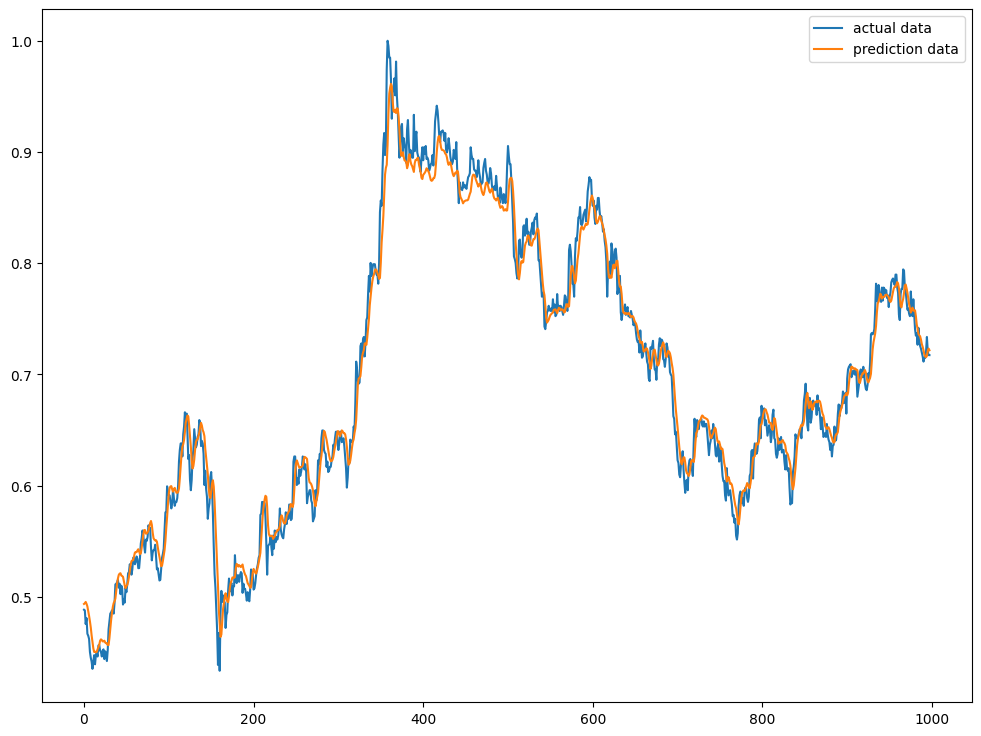

In [ ]:
# 예측 데이터 시각화
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(y_test)[20:], label='actual data')
plt.plot(pred, label='prediction data')
plt.legend()
plt.show()